In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles
from random import randint
import seaborn as sns

# K-Means Clustering

K-means clustering partitions datapoints by their closest centroid. The locations of the centroids are chosen to minimise the within-cluster variances (squared Euclidean distances). An example is shown below, with the centroids marked by red stars.

However, the efficacy of k-means clustering is dependent on the starting locations of the centroids. If multiple centroids begin too close to the same cluster, that cluster may be incorrectly partitioned.


In [2]:
class kmeans:

    def __init__(self):
        pass

    def distance(self, a, b):
        return np.sqrt(np.sum((a-b)**2))

    def add(self, a, b):
        c = [a[i] + b[i] for i in range(len(a))]
        return c

    def scale(self, a, s):
        c = [a[i] * s for i in range(len(a))]
        return c
    
    def assign_clusters(self, X, centroids, k):
        assignment = []
        for p in X:
            distances = []
            for i, c in enumerate(centroids):
                d = self.distance(p, c)
                distances.append((d,i))
            distances.sort()
            assignment.append(distances[0][1])
        return assignment

    def update_centroids(self, X, assignment, k):
        centroids = [[0 for _ in range(len(X[0]))] for i in range(k)]
        cluster_sizes = [0 for i in range(k)]
        for i in range(len(X)):
            centroids[assignment[i]] = self.add(centroids[assignment[i]], X[i])
            cluster_sizes[assignment[i]] += 1
        for i in range(k): centroids[i] = self.scale(centroids[i], 1/cluster_sizes[i])
        return centroids

    def fit(self, X, k=3):
        # randomly choose points
        centroids = [X[randint(0, len(X)-1)] for _ in range(k)]

        for _ in range(10):
            assignment = self.assign_clusters(X, centroids, k)
            centroids = self.update_centroids(X, assignment, k)
        assignment = self.assign_clusters(X, centroids, k)

        return np.array(assignment), np.array(centroids)

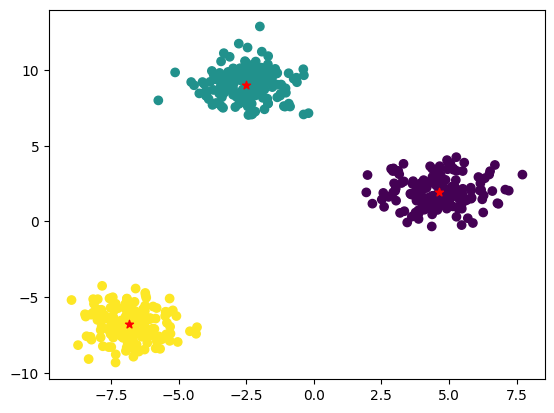

In [3]:
X,y = make_blobs(n_samples = 500,n_features = 2,centers = 3,random_state = 42)

KM = kmeans()

assignments, centroids = KM.fit(X)

fig = plt.figure(0)
plt.scatter(X[:,0],X[:,1], c=assignments)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='red')
plt.show()

K-Means is effective for spherical clusters. However, it cannot identify more complex structures:

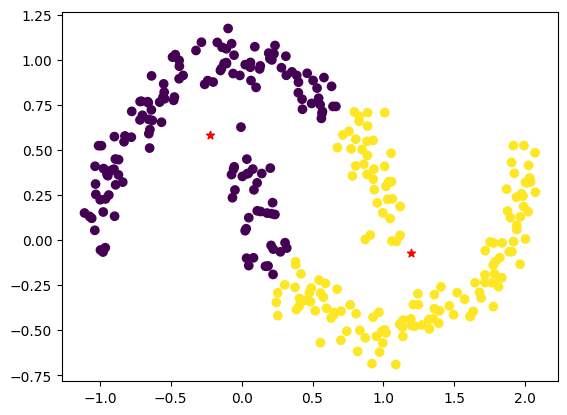

In [4]:
X = make_moons([150, 150], noise=0.08)[0]
KM = kmeans()
assignments, centroids = KM.fit(X, k=2)

fig = plt.figure(0)
plt.scatter(X[:,0],X[:,1], c=assignments)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='red')
plt.show()

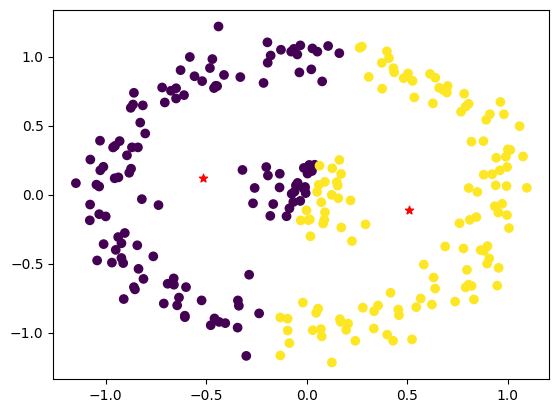

In [5]:
X = make_circles([200, 50], factor = 0.1, noise=0.1)[0]
KM = kmeans()
assignments, centroids = KM.fit(X, k=2)

fig = plt.figure(0)
plt.scatter(X[:,0],X[:,1], c=assignments)
plt.scatter(centroids[:,0], centroids[:,1], marker='*', c='red')
plt.show()

## Gaussian Mixture Model

A Gaussian Mixture Model is a probabilistic clustering model that decomposes a dataset into the sum of a series Gaussian distributions. This method assigns each data point a probability of belonging to each cluster. 

In [6]:
from scipy.stats import norm

def _plot_mixture(means, std, w):
    # Generate points for the x-axis
    x = np.linspace(-5, 10, 1000)

    # Calculate the individual nomral distributions
    normals = []
    for i in range(len(means)):
        normals.append(norm.pdf(x, means[i], std[i]))

    # Calculate the mixture
    mixture = w[0] * normals[0]
    for i in range(1, len(means)):
        mixture += w[i] * normals[i]
    
    # Plot the results
    for i in range(len(normals)):
        plt.plot(x, normals[i], label=f'Normal Distribution {i+1}', linestyle='--')
    plt.plot(x, mixture, label='Mixture Model', color='black')
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.legend(loc='best')

def sample_mixture(means, std, w, n_samples=100):
    x = np.zeros(n_samples)
    for i in range(n_samples):
        p = np.random.rand()
        for j in range(len(w)):
            if p < w[j]:
                # sample from this distribution
                x[i] = np.random.normal(means[j], std[j])
                break
            else:
                p -= w[j]

    return x    

The diagram below shows the sum of two weighted 1D Gaussian distributions. A dataset was generated by randomly sampling the two distributions.

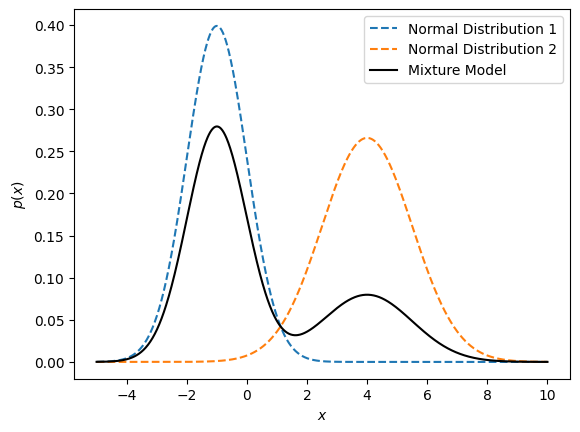

In [7]:
_means = [-1, 4]
_std = [1, 1.5]
_w = [0.7, 0.3]

_plot_mixture(_means, _std, _w)

In [8]:
class GMM:

    def __init__(self):
        pass

    def fit(self, X, k=3, max_iter=10):
        # randomly choose points
        means = [X[randint(0, len(X)-1)] for _ in range(k)]
        std = [1 for _ in range(k)]
        w = [1/k for _ in range(k)]

        for _ in range(max_iter):
            probs = self.e_step(X, means, std, w, k)
            means, std, w = self.m_step(X, probs, k)

        return means, std, w

    # expectation step
    def e_step(self, X, means, std, w, k):
        probs = []
        for i in range(k):
            p = norm(means[i], std[i]).pdf(X) * w[i]
            probs.append(p)

        # normalise
        prob_tot = sum(probs)
        for i in range(k): probs[i] /= prob_tot

        return np.array(probs)

    def m_step(self, X, probs, k):
        # update means
        means = []
        for i in range(k):
            means.append(np.dot(probs[i], X) / np.sum(probs[i]))
        means = np.array(means)

        # Update standard deviations
        std = []
        for i in range(k):
            std.append(np.sqrt(np.dot(probs[i], (X - means[i])**2) / np.sum(probs[i])))
        std = np.array(std)
    
        # Update mixing weights
        w = []
        for i in range(k):
            w.append(np.sum(probs[i]) / len(X))
        w = np.array(w)

        return means, std, w            

In [9]:
gmm = GMM()
X = sample_mixture(_means, _std, _w, n_samples=1000)
means, std, w = gmm.fit(X, max_iter=100, k=2)

In [10]:
def plot_mixture(x, means, std, w):
    # Plot an histogram of the input data
    sns.histplot(x, bins=50, kde=True, stat='density', linewidth=0.5, color='gray')

    # Generate points for the x-axis
    x_ = np.linspace(-5, 10, 1000)

    # Calculate the individual nomral distributions
    normals = []
    for i in range(len(w)):
        normals.append(norm.pdf(x_, means[i], std[i]))

    # Calculate the mixture
    mixture = w[0] * normals[0]
    for i in range(1, len(w)):
        mixture += w[i] * normals[i]

    # Plot the results
    for i in range(len(w)):
        plt.plot(x_, normals[i], label=f'Normal distribution {i+1}', linestyle='--')
    plt.plot(x_, mixture, label=f'Combined', c='red')
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.legend()

The dataset was then decomposed into its underlying normal distributions by the Gaussian Mixture Model, as shown below.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


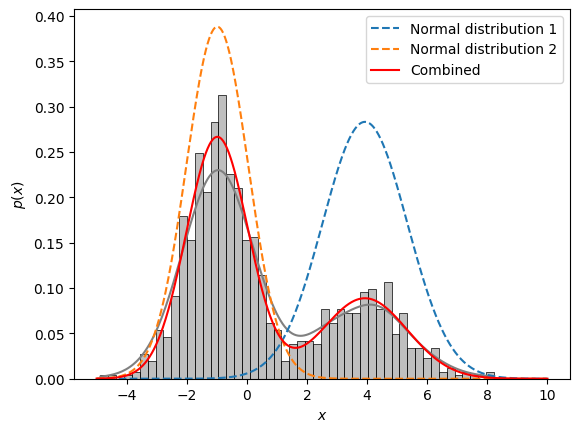

In [11]:
plot_mixture(X, means, std, w)

The Gaussian Mixture Model is able to decompose multiple distributions with high degrees of overlap, as shown below. However, the number of underlying distributions must be known in advance.

The Gaussian Mixture Model can be extended into multivariate clustering. It is effective for spheroid-shaped clusters but suffers when modelling more complex structures.	

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


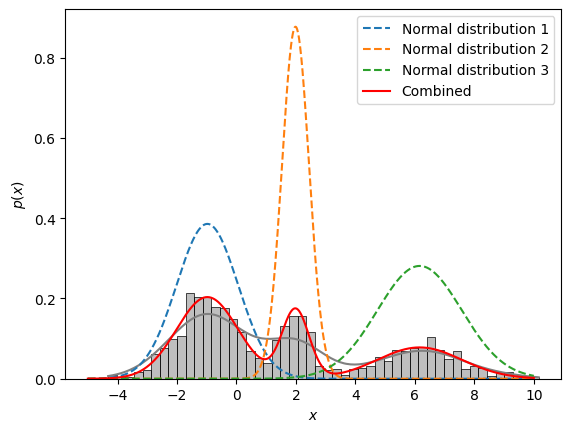

In [12]:
_means = [-1, 2, 6]
_std = [1, 0.5, 1.5]
_w = [0.5, 0.2, 0.3]

gmm = GMM()
X = sample_mixture(_means, _std, _w, n_samples=1000)
means, std, w = gmm.fit(X, max_iter=100, k=3)

plot_mixture(X, means, std, w)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


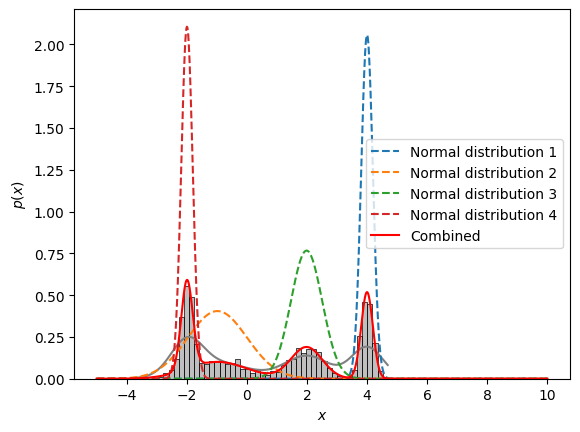

In [13]:
_means = [-2,-1, 2, 4]
_std = [0.2, 1, 0.5, 0.2]
_w = [0.25, 0.25, 0.25, 0.25]

gmm = GMM()
X = sample_mixture(_means, _std, _w, n_samples=3000)
means, std, w = gmm.fit(X, max_iter=100, k=4)

plot_mixture(X, means, std, w)

## Local Outlier Factor (LOF)

The Local Outlier Factor is a tool for detecting anomalies in a dataset using the local density around datapoints. If a point has a significantly lower local density than its nearest neighbours, it is classified as an outlier. 

In [14]:
from functools import lru_cache

def distance2(a, b):
    return np.sum((a-b)**2)

class LocalOutlier:
    def __init__(self):
        pass

    def RD(self, i, j):
        K = self.distances[j]
        return max(K, distance2(self.X[i], self.X[j]))

    def LRD(self, a):
        tot = 0
        for j in self.neighbours[a]:
            tot += self.RD(a, j)
        tot /= len(self.neighbours[a])
        return 1 / tot

    def LOF(self, a):
        tot = 0
        for j in self.neighbours[a]:
            tot += self.LRD(j)
        tot /= len(self.neighbours[a])
        tot /= self.LRD(a)
        return tot        

    def fit(self, X, k=3):
        # k distances
        self.X = X
        distances = []
        for i in range(len(X)):
            d = []
            for j in range(len(X)):
                if i != j:
                    d.append((distance2(X[i], X[j]), j))
            distances.append(d)

        self.neighbours = []
        for i in range(len(distances)):
            distances[i].sort()
            dist = distances[i][k-1][0]
            neighbours = []
            for j in range(len(distances[i])):
                if distances[i][j][0] <= dist:
                    neighbours.append(distances[i][j][1])
            distances[i] = dist
            self.neighbours.append(neighbours)
        self.distances = distances

        LOFs = []
        for i in range(len(X)):
            LOFs.append(self.LOF(i))
        return LOFs
                    

The local density of a point is calculated using its k-distance, the distance to its kth nearest neighbour. The circular k-distances (k = 2) about four points are shown below.

The local density about D is clearly much lower than the local densities about the above points, suggesting it to be an anomaly. 

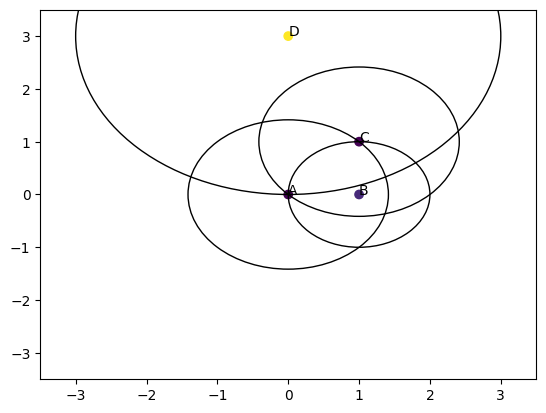

In [15]:
points = np.array([[0,0], [1,0], [1,1], [0,3]])
ALPHA = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

LOF = LocalOutlier()
factors = LOF.fit(points, k=2)

ax = plt.gca()
ax.cla()
ax.scatter(points[:,0], points[:,1], label=ALPHA[:len(points)], c=factors)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)
r = [2, 1, 2, 9]
for i in range(4):
    c = plt.Circle(points[i], r[i]**0.5, fill=False)
    ax.add_patch(c)
    ax.annotate(ALPHA[i], points[i])

plt.show()

A larger example (k = 5) is shown below. Points that are more yellow have a larger outlier factor (and so are more likely to be outliers), whilst points that are more purple have smaller outlier factors.

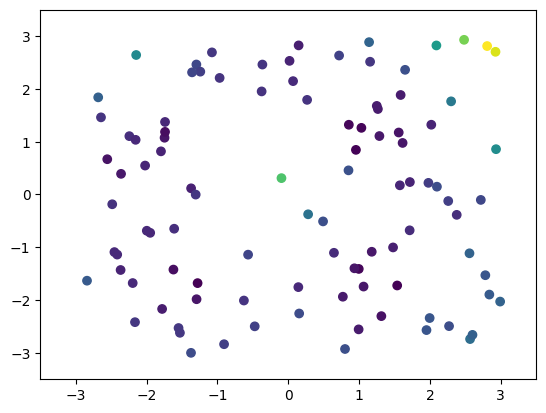

In [16]:
num_points = 100
points = np.random.rand(num_points,2)*6 - np.array([[3,3] for _ in range(num_points)])

ALPHA = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

LOF = LocalOutlier()
factors = LOF.fit(points, k=10)

ax = plt.gca()
ax.cla()
ax.scatter(points[:,0], points[:,1], label=ALPHA[:len(points)], c=factors)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)

plt.show()

Since local density is used, rather than square Euclidean distance, the Local Outlier Factor can be used on clusters with complex structures:

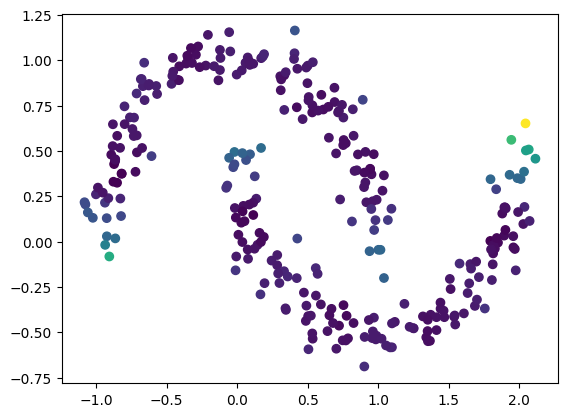

In [17]:
points = make_moons([150, 150], noise=0.08)[0]
ALPHA = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

LOF = LocalOutlier()
factors = LOF.fit(points, k=20)

ax = plt.gca()
ax.cla()
ax.scatter(points[:,0], points[:,1], label=ALPHA[:len(points)], c=factors)

plt.show()

## DBSCAN

In [18]:
class UnionFind:

    def __init__(self, n):
        self.parents = [i for i in range(n)]

    def get_parent(self, i):
        if self.parents[i] == i: return i
        p = self.get_parent(self.parents[i])
        self.parents[i] = p
        return p

    def union(self, a, b):
        a = self.get_parent(a)
        b = self.get_parent(b)
        a, b = min(a,b), max(a,b)
        self.parents[b] = a

    def get_groups(self):
        groups = dict()
        for i in range(len(self.parents)):
            p = self.get_parent(i)
            if p not in groups: groups[p] = set()
            groups[p].add(i)
        return groups

    def flatten_parents(self):
        for i in range(len(self.parents)):
            self.parents[i] = self.get_parent(i)

class DBSCAN:

    def __init__(self):
        pass

    def fit(self, X, eps=2, minPts=2):
        UNKNOWN = 0
        CORE = 1
        BORDER = 2
        NOISE = 3
        
        self.X = X
        self.eps = eps

        classifications = [BORDER for _ in range(len(X))]

        # neighbours
        neighbours = []
        for i in range(len(X)):
            neigh = []
            for j in range(len(X)):
                if i == j: continue
                if distance2(X[i], X[j]) <= eps**2:
                    neigh.append(j)
            neighbours.append(neigh)

        # cores
        for i in range(len(X)):
            if len(neighbours[i]) >= minPts:
                classifications[i] = CORE

        # clusters
        clusters = UnionFind(len(X))
        for i in range(len(X)):
            for j in neighbours[i]:
                if classifications[j] == CORE:
                    clusters.union(i, j)

        clusters.flatten_parents()
        return clusters.parents
        

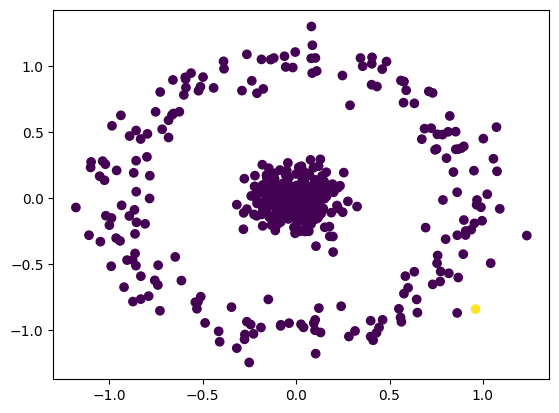

In [19]:
points = make_circles([200, 300], factor = 0.1, noise=0.1)[0]
db = DBSCAN()
clusters = db.fit(points, eps=0.25, minPts=5)
plt.scatter(points[:,0], points[:,1], c=clusters)
plt.show()

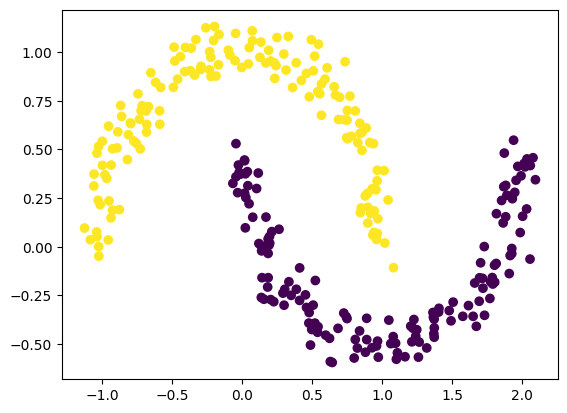

In [20]:
points = make_moons([150, 150], noise=0.08)[0]
db = DBSCAN()
clusters = db.fit(points, eps=0.15, minPts=5)
for i in range(len(clusters)): 
    if clusters[i] > 10: clusters[i] = 10
plt.scatter(points[:,0], points[:,1], c=clusters)
plt.show()

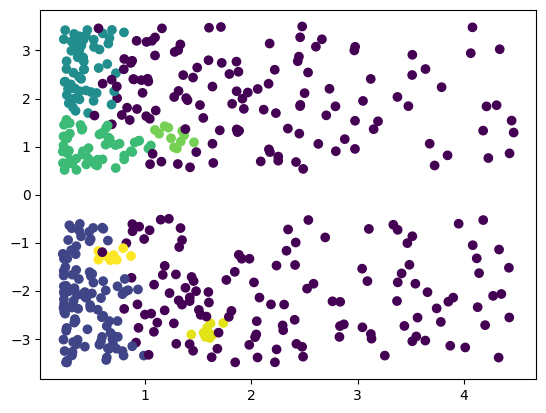

In [21]:
num_points = 500
points = np.random.rand(num_points,2)*6 - np.array([[3,3] for _ in range(num_points)])
for i in range(len(points)):
    points[i][0] = np.exp(points[i][0]/2)
    if points[i][1] < 0: points[i][1] -= 0.5
    else: points[i][1] += 0.5

db = DBSCAN()
clusters = db.fit(points, eps=0.2, minPts=5)

for i in range(len(clusters)): 
    if clusters.count(clusters[i]) == 1: clusters[i] = -1
    if clusters[i] > 0: clusters[i] = np.log(clusters[i])

plt.scatter(points[:,0], points[:,1], c=clusters)
plt.show()

plt.show()

## Conclusion

Clustering algorithms are power tools for grouping unlabelled data and detecting anomalies. 
K-Means clustering is a simple and efficient algorithm for partitioning data into a fixed number of roughly spherical clusters. Due to its distance-based approach, it breaks down when trying to model more complex structures.

The Gaussian Mixture Model improves on K-Means by handling elongated and overlapping clusters. By assuming the data can be modelled as a sum of Gaussian distributions, it assigns probabilities for each point belonging to each cluster. These probabilities can then be used to detect outliers. The Gaussian Mixture Model is often used for spectral deconvolution when processing signals. 
The Local Outlier Factor uses local density rather than distance to detect anomalies in a dataset. It can thus handle datasets with a complex structure.

DBSCAN extends the idea of local density to form clusters from extended regions of high density. Its density-based approach allows it to model complex structures with an unknown number of clusters. Any points that are not assigned to a cluster are assumed to be outliers. 